In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans

lmodel = LinearRegression()

# Read in CSV's to pandas
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
labels=train["SalePrice"]

model_data = pd.concat([train,test],ignore_index=True)
model_data = model_data.drop("SalePrice", 1)

In [2]:
# Get dummies and check variance for what are important features


In [3]:
# Store id's for rows with nan
nan_indices_lot_frontage = model_data['LotFrontage'].index[model_data['LotFrontage'].apply(np.isnan)]
print len(nan_indices_lot_frontage)

# Drop seemingly useless cols that have nan
model_data = model_data.drop(["GarageYrBlt", ])

486


ValueError: labels ['GarageYrBlt'] not contained in axis

In [4]:
model_data.loc[:, "MSSubClass":"OverallCond"].values

array([[60, 'RL', 196.0, ..., 'CollgCr', 61, 5],
       [20, 'RL', 0.0, ..., 'Veenker', 0, 8],
       [60, 'RL', 162.0, ..., 'CollgCr', 42, 5],
       ..., 
       [20, 'RL', 0.0, ..., 'Mitchel', 0, 7],
       [85, 'RL', 0.0, ..., 'Mitchel', 32, 5],
       [60, 'RL', 94.0, ..., 'Mitchel', 48, 5]], dtype=object)

In [5]:
# change nan to mean to start
model_data["LotFrontage"] = model_data["LotFrontage"].fillna(model_data["LotFrontage"].mean())

# KMeans to find values for nan features
k = 9
k_data = np.column_stack(model_data.loc[:, "MSSubClass":"OverallCond"].values)
kmeans = KMeans(n_clusters=k, random_state=0).fit(k_data)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
k_data[nan_indices_lot_frontage]

ValueError: could not convert string to float: Mitchel

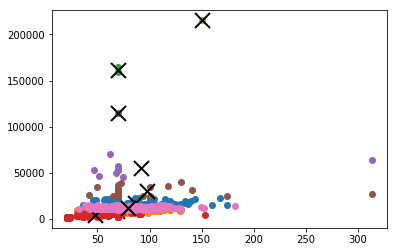

In [278]:
# Check out our clustering
for i in range(k):
    # select only data observations with cluster label == i
    ds = k_data[np.where(labels==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)
plt.show()

In [279]:
# Check LotFrontage values that were previously nan
k_data[nan_indices_lot_frontage]

array([[  7.00499584e+01,   1.03820000e+04,   1.22060776e+01],
       [  7.00499584e+01,   1.29680000e+04,   1.18775755e+01],
       [  7.00499584e+01,   1.09200000e+04,   1.19640075e+01],
       [  7.00499584e+01,   1.12410000e+04,   1.19117083e+01],
       [  7.00499584e+01,   8.24600000e+03,   1.19447144e+01],
       [  7.00499584e+01,   8.54400000e+03,   1.19140545e+01],
       [  7.00499584e+01,   9.18000000e+03,   1.18775755e+01],
       [  7.00499584e+01,   9.20000000e+03,   1.17772186e+01],
       [  7.00499584e+01,   1.38690000e+04,   1.20839107e+01],
       [  7.00499584e+01,   9.37500000e+03,   1.22991121e+01],
       [  7.00499584e+01,   1.99000000e+04,   1.21007177e+01],
       [  7.00499584e+01,   8.47500000e+03,   1.18185776e+01],
       [  7.00499584e+01,   8.53000000e+03,   1.20346970e+01],
       [  7.00499584e+01,   9.76500000e+03,   1.21281165e+01],
       [  7.00499584e+01,   1.06030000e+04,   1.22307701e+01],
       [  7.00499584e+01,   7.75800000e+03,   1.2040614

In [280]:
prev_labels = []
converged = False

while(converged == False):
    for frontage_nan in nan_indices_lot_frontage:
        # Set LotFrontage value that was previously nan to
        # centroid for the k_data point at that same index
        k_data[frontage_nan][0] = centroids[labels[frontage_nan]][0]

    # Rerun KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(k_data)
    # Store new labels
    labels = kmeans.labels_
    print labels
    # If labels did not change in this run, algorithm has converged 
    # (is this error prone if the window of distance to centroid is large?)
    if np.all(labels == prev_labels):
        converged = True

    prev_labels = labels

[1 1 6 ..., 1 1 1]
[1 1 6 ..., 1 1 1]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [281]:
# Check LotFrontage values that were previously nan after convergance
k_data[nan_indices_lot_frontage]

print model_data

        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60    65.000000     8450            7            5   
1        2          20    80.000000     9600            6            8   
2        3          60    68.000000    11250            7            5   
3        4          70    60.000000     9550            7            5   
4        5          60    84.000000    14260            8            5   
5        6          50    85.000000    14115            5            5   
6        7          20    75.000000    10084            8            5   
7        8          60    70.049958    10382            7            6   
8        9          50    51.000000     6120            7            5   
9       10         190    50.000000     7420            5            6   
10      11          20    70.000000    11200            5            5   
11      12          60    85.000000    11924            9            5   
12      13          20    70.049958   

In [282]:
# Add new frontage values back into model at the previously nan indices
for i, model_lot_frontage in enumerate(model_data["LotFrontage"]):
    if i in nan_indices_lot_frontage:
        model_data["LotFrontage"][i] = k_data[i][0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [283]:
# Fit the model to the Sales values that we want to predict
lmodel.fit(model_data.loc[:, "MSSubClass":"OverallCond"], train.SalePrice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [284]:
# store how predictions from the data that we trained on
results = lmodel.predict(model_data.loc[:, "MSSubClass":"OverallCond"])

# get mean squared error
print(mean_squared_error(train.SalePrice, results))

0.0455004434363
